In [ ]:
# Build user_reports_data from df_user for GCN / fusion grid-search
# Run this cell before the fusion-weight grid-search cell.
import ast

user_reports_data = []
if 'df_user' in globals() and not df_user.empty:
    for _, r in df_user.iterrows():
        postId = r.get('post_id') or r.get('postId') or None
        urls = r.get('urls') or []
        # if stored as string, try to parse
        if isinstance(urls, str):
            try:
                urls = ast.literal_eval(urls)
            except Exception:
                urls = [urls]
        rtype = r.get('type') if 'type' in r.index else None
        true_label = None
        try:
            if 'label' in r.index and (int(r['label']) == 0 or int(r['label']) == 1):
                true_label = int(r['label'])
            else:
                true_label = 1 if (rtype in ('false_negative', 'true_positive')) else 0
        except Exception:
            true_label = 0 if (rtype in ('true_negative','false_positive')) else 0
        user_reports_data.append({'postId': postId, 'true_label': true_label, 'urls': urls})
    print('Built user_reports_data with', len(user_reports_data), 'entries')
else:
    print('df_user not present or empty; user_reports_data not created')



In [ ]:
# Auto-split post IDs into train_post_ids and test_post_ids (stratified by majority post label)
from collections import Counter
from sklearn.model_selection import train_test_split

train_post_ids = []
test_post_ids = []

if 'user_reports_data' in globals() and len(user_reports_data) > 0:
    post_to_labels = {}
    for r in user_reports_data:
        pid = r.get('postId')
        if not pid:
            continue
        post_to_labels.setdefault(pid, []).append(int(r.get('true_label', 0)))

    post_ids = []
    labels = []
    for pid, labs in post_to_labels.items():
        # majority label for the post
        lab = int(round(sum(labs) / len(labs)))
        post_ids.append(pid)
        labels.append(lab)

    print(f'Found {len(post_ids)} unique posts with labels. Label distribution:', Counter(labels))

    if len(post_ids) < 2:
        print('Not enough posts to split; assigning all to train.')
        train_post_ids = post_ids
        test_post_ids = []
    else:
        try:
            train_post_ids, test_post_ids = train_test_split(post_ids, test_size=0.2, stratify=labels, random_state=SEED)
        except Exception:
            # fallback to unstratified split
            train_post_ids, test_post_ids = train_test_split(post_ids, test_size=0.2, random_state=SEED)

    # show splits
    def label_counts(ids):
        cnt = Counter()
        for pid in ids:
            labs = post_to_labels.get(pid, [])
            if labs:
                cnt.update([int(round(sum(labs)/len(labs)))])
        return dict(cnt)

    print('Train posts:', len(train_post_ids), 'label dist:', label_counts(train_post_ids))
    print('Test posts :', len(test_post_ids), 'label dist:', label_counts(test_post_ids))

else:
    print('user_reports_data not found or empty; cannot auto-split post IDs')



-----

### **AE (with Fine-Tuning) + GCN Training Notebook**
  * **Part 1**: A Deep Autoencoder is **pre-trained** on a large public dataset and then **fine-tuned** using user-reported benign URLs from Firestore.
  * **Part 2**: The Graph Convolutional Network (GCN) is trained on your user reports from Firestore to learn structural patterns.
  * **Part 3**: The fine-tuned AE and the trained GCN are fused and evaluated.
  * **Part 4**: All necessary artifacts for the backend API are exported.
-----

#### **1. Setup and Installations**

In [1]:
# Install core data science and cloud libraries
!pip -q install pandas scikit-learn==1.7.1 tldextract google-cloud-firestore

# Install TensorFlow for the Autoencoder
!pip -q install tensorflow==2.19.0 tf-keras==2.19.0 "protobuf>=5.26.1"

# Install PyTorch and PyTorch Geometric for the GNN
!pip -q install torch==2.3.1 torchvision==0.18.1 --index-url https://download.pytorch.org/whl/cpu
!pip -q install torch_geometric -f https://data.pyg.org/whl/torch-2.3.1+cpu.html

# Install visualization libraries
!pip -q install matplotlib seaborn

print("✅ All libraries installed successfully.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.74.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.


✅ All libraries installed successfully.


-----

#### **2. Imports and Initial Configuration**

In [2]:
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns

# ML/DL Frameworks
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Scikit-learn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Google Cloud and Colab
from google.colab import files
from google.cloud import firestore

# --- Reproducibility ---
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

ModuleNotFoundError: No module named 'google.colab'

-----

### **Part 1: Autoencoder Pre-Training and Fine-Tuning**

This part now includes both the initial training on public data and the specialized fine-tuning on user's data.

#### **3. Load Public Dataset and Authenticate**

In [ ]:
# The public dataset contains 111 lexical features extracted from URLs
URL = "https://raw.githubusercontent.com/GregaVrbancic/Phishing-Dataset/master/dataset_full.csv"
print("Downloading public dataset...")
df_base = pd.read_csv(URL)

# Separate features (X) from the label (y)
y_public = df_base["phishing"].astype(int).values
X_public = df_base.drop(columns=["phishing"]).astype(np.float32)
feature_cols = X_public.columns.tolist()

print(f"Dataset loaded with {X_public.shape[0]} samples and {X_public.shape[1]} features.")

# Split public data for pre-training and getting a baseline
X_tr, X_te, y_tr, y_te = train_test_split(X_public, y_public, test_size=0.30, stratify=y_public, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.20, stratify=y_tr, random_state=42)

# --- Feature Scaling ---
# Fit the scaler ONLY on benign training data to learn the "normal" distribution
# Toggle between StandardScaler (for reproducibility per thesis) and RobustScaler (recommended)
import os
use_standard_scaler = os.environ.get('STANDARD_SCALER', '0').lower() in ('1','true','yes')
if use_standard_scaler:
    print('Using StandardScaler as requested for thesis reproducibility')
    scaler = StandardScaler().fit(X_tr[y_tr==0])
    scaler_type = 'StandardScaler'
else:
    print('Using RobustScaler for improved robustness to outliers')
    scaler = RobustScaler().fit(X_tr[y_tr==0])
    scaler_type = 'RobustScaler'

# Transform all datasets using this scaler
X_tr_s = scaler.transform(X_tr)
X_val_s = scaler.transform(X_val)
X_te_s = scaler.transform(X_te)
print('Scaler type:', scaler_type)

print("Data successfully split and scaled.")

# --- Firebase Authentication ---
print("\nPlease upload your Firebase service account JSON key file.")
uploaded = files.upload()
sa_path = next(iter(uploaded.keys()))
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = sa_path
print("\n✅ Firebase authentication configured.")

Dataset loaded with 88647 samples and 111 features.
Data successfully split and scaled.

Please upload your Firebase service account JSON key file.


Saving firebase-sa.json to firebase-sa (3).json

✅ Firebase authentication configured.


In [ ]:
# --- Optional: Add external phishing dataset (Mendeley DOI) ---
# Tamal, Maruf (2023), "Phishing Detection Dataset", Mendeley Data, V1, doi: 10.17632/6tm2d6sz7p.1
import requests, zipfile, io, os

print('Attempting to fetch Mendeley dataset via DOI. If automated download fails, please manually download the dataset and upload it to Colab.')

def try_download_doi(doi, dest_dir='external_dataset'):
    os.makedirs(dest_dir, exist_ok=True)
    doi_url = f'https://doi.org/{doi}'
    try:
        r = requests.head(doi_url, allow_redirects=True, timeout=10)
        final = r.url
        print('Resolved DOI to:', final)
        # If final is a zip or direct file, download
        if final.endswith('.zip') or 'mendeley' in final:
            print('Downloading archive...')
            rr = requests.get(final, stream=True, timeout=30)
            rr.raise_for_status()
            z = zipfile.ZipFile(io.BytesIO(rr.content))
            z.extractall(dest_dir)
            print('Extracted to', dest_dir)
            return dest_dir
        else:
            # Not direct; fallback: ask user to download manually
            print('DOI did not resolve to a direct file. Please download the dataset from the Mendeley Data page and upload it here.')
            return None
    except Exception as e:
        print('Automated DOI fetch failed:', e)
        return None

# Try to download; if it fails, prompt the user to upload a dataset file
external_dir = try_download_doi('10.17632/6tm2d6sz7p.1')
if external_dir is None:
    print('\nIf you have the dataset ZIP/CSV file, upload it now via the Files UI or using:')
    print("from google.colab import files; files.upload()")
else:
    # Discover CSV files in the extracted directory
    csv_files = []
    for root, dirs, files in os.walk(external_dir):
        for f in files:
            if f.lower().endswith('.csv'):
                csv_files.append(os.path.join(root, f))
    print('Found CSV files:', csv_files)
    if csv_files:
        # Load first CSV and try to integrate
        df_ext = pd.read_csv(csv_files[0])
        print('External dataset shape:', df_ext.shape)
        # If df_ext contains a URL column, compute features and append to df_base
        url_cols = [c for c in df_ext.columns if 'url' in c.lower()]
        if url_cols:
            print('Detected URL column(s):', url_cols)
            urls = df_ext[url_cols[0]].astype(str).tolist()
            feats_df = pd.DataFrame([features_for_url(u) for u in urls], columns=feature_cols)
            # If label exists in df_ext, attach it
            label_col = None
            for c in df_ext.columns:
                if c.lower() in ('phishing','label','is_phishing'):
                    label_col = c
                    break
            if label_col is not None:
                feats_df['phishing'] = df_ext[label_col].astype(int).values
            else:
                feats_df['phishing'] = 0
            # Merge into df_base (append)
            df_base = pd.concat([df_base, feats_df], ignore_index=True)
            print('Appended external dataset; new df_base shape:', df_base.shape)
        else:
            print('No URL column detected in external CSV; please preprocess externally to provide URLs or feature columns.')

print('External dataset integration step complete.')


-----

#### **4. Define and Pre-train the Autoencoder**

We train the AE on the large public dataset to give it a strong general foundation.

In [ ]:
# Autoencoder hyperparameters (from thesis)
AE_LAYER1 = 64
AE_LAYER2 = 32
AE_BOTTLENECK = 16
AE_DROPOUT = 0.1
LR_PRETRAIN = 1e-3
BATCH_PRETRAIN = 512
EPOCHS_PRETRAIN = 30
LR_FINETUNE = 1e-5
BATCH_FINETUNE = 16
EPOCHS_FINETUNE = 50

# Define the Autoencoder architecture (as in thesis)
inp = keras.Input(shape=(X_tr_s.shape[1],))
x = keras.layers.Dense(AE_LAYER1, activation='relu')(inp)
x = keras.layers.Dropout(AE_DROPOUT)(x)
x = keras.layers.Dense(AE_LAYER2, activation='relu')(x)
z = keras.layers.Dense(AE_BOTTLENECK, activation='relu')(x)  # Bottleneck
x = keras.layers.Dense(AE_LAYER2, activation='relu')(z)
x = keras.layers.Dense(AE_LAYER1, activation='relu')(x)
out = keras.layers.Dense(X_tr_s.shape[1])(x)

ae_model = keras.Model(inp, out)
ae_model.compile(optimizer=keras.optimizers.Adam(LR_PRETRAIN), loss='mse')

print('--- Step 1: Pre-training Autoencoder on Public Dataset ---')
history = ae_model.fit(
    X_tr_s[y_tr == 0], X_tr_s[y_tr == 0],
    validation_data=(X_val_s[y_val == 0], X_val_s[y_val == 0]),
    epochs=EPOCHS_PRETRAIN,
    batch_size=BATCH_PRETRAIN,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
)

print('\n✅ Pre-training complete.')

--- Step 1: Pre-training Autoencoder on Public Dataset ---
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.7498 - val_loss: 0.4534
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3637 - val_loss: 0.3896
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3087 - val_loss: 0.3507
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2693 - val_loss: 0.3208
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2417 - val_loss: 0.2987
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2221 - val_loss: 0.2830
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2042 - val_loss: 0.2638
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1901 - val_loss: 0.2530
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1794 - val_loss: 0.2399
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1694 - val_loss: 0.2292
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1617 - val_loss: 0.2193
Epoc

# 4.5. Pre-train Evaluation

This new cell evaluates the performance of the Autoencoder before it has been fine-tuned. This gives us a baseline to measure improvement against.

In [ ]:
# --- Updated Pre-train Evaluation (uses current preprocessing + AE->prob mapping) ---
print("\n--- Evaluating Pre-trained Autoencoder Performance (using current preprocessing) ---")

# Reconstruct benign portion of public validation using current scaler / features
pretrain_val_reconstructed = ae_model.predict(X_val_s[y_val == 0], verbose=0)
pretrain_val_error = np.mean((pretrain_val_reconstructed - X_val_s[y_val == 0])**2, axis=1)

# Default pretrain threshold: 99th percentile of benign validation errors (keeps high precision)
pretrain_ae_threshold = float(np.percentile(pretrain_val_error, 99.0))

# Evaluate on the public test set (transform already computed earlier: X_te_s)
test_reconstructed = ae_model.predict(X_te_s, verbose=0)
test_error = np.mean((test_reconstructed - X_te_s)**2, axis=1)

# Convert errors -> AE probability consistently with later code
ae_prob_test = np.clip((test_error - pretrain_ae_threshold * 0.5) / (pretrain_ae_threshold * 2), 0, 1)

# Binary predictions using the AE probability threshold of 0.5
y_pred_pretrain = (ae_prob_test > 0.5).astype(int)

# Define local print_stats (ensures availability regardless of cell order)
def print_stats(model_name, y_true, y_pred):
    stats = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }
    print(f"\n--- {model_name} ---")
    for key, value in stats.items():
        print(f"  {key.capitalize():<18}: {value if key == 'confusion_matrix' else f'{value:.4f}'}")
    return stats

# Print metrics
pretrain_stats = print_stats("Pre-trained AE (Baseline on Public Data)", y_te, y_pred_pretrain)

# Also report ROC/PR AUC on continuous AE score for diagnostics
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
try:
    roc = roc_auc_score(y_te, test_error)  # higher error => positive
except Exception:
    roc = None
prec, rec, _ = precision_recall_curve(y_te, test_error)
pr_auc = auc(rec, prec)
print(f"ROC AUC (error as score): {roc}, PR AUC: {pr_auc:.4f}")

# Save the pretrain threshold for reference (optional)
try:
    with open('pretrain_ae_threshold.txt', 'w') as f:
        f.write(str(pretrain_ae_threshold))
    print('Saved pretrain_ae_threshold.txt')
except Exception:
    pass

print('\nPretrain threshold (99th percentile benign val) =', pretrain_ae_threshold)



In [ ]:
# --- Pre-train Evaluation ---
print("\n--- Evaluating Pre-trained Autoencoder Performance ---")

# Determine a temporary threshold based on the pre-trained model
pretrain_val_reconstructed = ae_model.predict(X_val_s[y_val==0], verbose=0)
pretrain_val_error = np.mean((pretrain_val_reconstructed - X_val_s[y_val==0])**2, axis=1)
pretrain_ae_threshold = float(np.percentile(pretrain_val_error, 99.0))

# Evaluate on the public test set
test_reconstructed = ae_model.predict(X_te_s, verbose=0)
test_error = np.mean((test_reconstructed - X_te_s)**2, axis=1)
y_pred_pretrain = (test_error > pretrain_ae_threshold).astype(int)

# Define the evaluation function
def print_stats(model_name, y_true, y_pred):
    stats = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }
    print(f"\n--- {model_name} ---")
    for key, value in stats.items():
        print(f"  {key.capitalize():<18}: {value if key == 'confusion_matrix' else f'{value:.4f}'}")
    return stats

# Print the pre-train stats
pretrain_stats = print_stats("Pre-trained AE (Baseline on Public Data)", y_te, y_pred_pretrain)


--- Evaluating Pre-trained Autoencoder Performance ---

--- Pre-trained AE (Baseline on Public Data) ---
  Accuracy          : 0.7525
  Precision         : 0.9421
  Recall            : 0.3026
  F1                : 0.4581
  Confusion_matrix  : [[17230, 171], [6412, 2782]]


-----

#### **5. Fine-Tune the Autoencoder with User Reports**

This is the new, crucial step. We continue training the AE, but only on the benign URLs reported by users.

In [ ]:
# --- Fetch and Process User Reports for Fine-tuning and Evaluation ---
APP_ID = "ads-phishing-link"
REPORTS_PATH = f"artifacts/{APP_ID}/private_user_reports"
db = firestore.Client()
print(f"\nFetching all user reports for processing...")
try:
    report_docs = list(db.collection(REPORTS_PATH).stream())
    print(f"Found {len(report_docs)} total user reports.")
except Exception as e:
    print(f"❌ Error fetching from Firestore: {e}")
    report_docs = []

# --- Create Unified Labeled URL Dataset from All Reports (with aggregation) ---
# Aggregate user reports into votes per-URL and per-post, then trust only high-confidence labels
from collections import defaultdict, Counter

# Map report types to label intents
type_to_label = {
    'true_positive': 1,
    'false_negative': 1,
    'true_negative': 0,
    'false_positive': 0
}

# Collect votes
url_votes = defaultdict(list)
post_votes = defaultdict(list)
for doc in report_docs:
    d = doc.to_dict()
    rtype = d.get('type')
    label = type_to_label.get(rtype, None)
    payload = d.get('payload') or {}
    links = payload.get('links') or []
    if isinstance(links, str):
        links = [links]
    if payload.get('url') and payload.get('url') not in links:
        links.append(payload.get('url'))
    for u in set([x for x in links if x]):
        if label is not None:
            url_votes[u].append(label)
    if payload.get('postId') and label is not None:
        post_votes[payload.get('postId')].append(label)

# Decide trust rules
MIN_VOTES = 1  # loosen to include single-vote reports for more training signal
trusted_url_labels = {}
for u, votes in url_votes.items():
    if len(votes) >= MIN_VOTES:
        c = Counter(votes)
        trusted_label = 1 if c[1] > c[0] else 0
        trusted_url_labels[u] = {'label': trusted_label, 'votes': len(votes), 'pos': c[1], 'neg': c[0]}

# Build df_user from trusted labels; fallback to all reports if none trusted
user_url_data = []
if len(trusted_url_labels) > 0:
    for u, info in trusted_url_labels.items():
        user_url_data.append({'url': u, 'label': info['label'], 'votes': info['votes']})
    print(f"Using {len(trusted_url_labels)} trusted URL labels (min_votes={MIN_VOTES}) for fine-tuning.)")
else:
    # Fallback: use all reported URLs but mark as low confidence
    print("No trusted URL labels found (not enough consensus). Falling back to all user reports (low confidence).")
    for doc in report_docs:
        d = doc.to_dict()
        payload = d.get('payload', {})
        links = payload.get('links') or []
        if isinstance(links, str): links = [links]
        if payload.get('url') and payload.get('url') not in links:
            links.append(payload.get('url'))
        label = 1 if d.get('type') in ('false_negative','true_positive') else 0
        for u in set([x for x in links if x]):
            user_url_data.append({'url': u, 'label': label})

# Create DataFrame
df_user = pd.DataFrame(user_url_data).drop_duplicates().reset_index(drop=True)
print(f"Created a unified dataset of {len(df_user)} unique user-reported URLs (post-aggregation).")

# --- Feature Extraction Function ---
feat_means_map = df_base[feature_cols].mean().to_dict()

# Helper: normalize URL by removing tracking params (fbclid, utm_*)
from urllib.parse import urlparse, urlunparse, parse_qsl, urlencode

def normalize_url_for_features(raw_url: str) -> str:
    try:
        p = urlparse(raw_url or "")
        if p.query:
            q = parse_qsl(p.query, keep_blank_values=True)
            q_filtered = [(k, v) for k, v in q if not (k.lower() == 'fbclid' or k.lower().startswith('utm_'))]
            p = p._replace(query=urlencode(q_filtered))
        return urlunparse(p)
    except Exception:
        return raw_url or ""

# Helper: stabilize heavy-tailed features prior to scaling/training
import numpy as np

def stabilize_features(feat_dict: dict) -> dict:
    # Stricter clipping to limit extreme z-scores from rare large counts
    feat_dict['qty_questionmark_url'] = min(max(int(feat_dict.get('qty_questionmark_url', 0)), 0), 3)
    feat_dict['qty_slash_url'] = min(max(int(feat_dict.get('qty_slash_url', 0)), 0), 10)
    feat_dict['qty_dot_url'] = min(max(int(feat_dict.get('qty_dot_url', 0)), 0), 6)
    feat_dict['qty_hyphen_url'] = min(max(int(feat_dict.get('qty_hyphen_url', 0)), 0), 10)

    # Binarize or clip other count-style features
    feat_dict['url_shortened'] = 1.0 if feat_dict.get('url_shortened', 0) else 0.0

    # Log-transform length and timing-like numeric features to compress dynamic range
    for key in ['file_length','directory_length','params_length','time_domain_activation','time_domain_expiration','ttl_hostname','asn_ip','time_response']:
        if key in feat_dict and feat_dict[key] is not None:
            try:
                feat_dict[key] = float(np.log1p(max(0.0, float(feat_dict[key]))))
            except Exception:
                pass

    # Keep other defaults intact
    return feat_dict


def features_for_url(url: str) -> np.ndarray:
    u = normalize_url_for_features(url)
    try:
        parts = tldextract.extract(u)
        domain = ".".join(p for p in [parts.subdomain, parts.domain, parts.suffix] if p)
        lex_feats = {
            'qty_dot_url': u.count('.'), 'qty_hyphen_url': u.count('-'), 'qty_slash_url': u.count('/'),
            'qty_questionmark_url': u.count('?'), 'qty_equal_url': u.count('='), 'qty_at_url': u.count('@'), 'length_url': len(u),
            'qty_dot_domain': domain.count('.'), 'qty_hyphen_domain': domain.count('-'), 'domain_length': len(domain),
            # conservative defaults for other fields; will be filled from feat_means_map when missing
            'url_shortened': 1.0 if any(s in (parts.domain or '').lower() for s in ['bit','tinyurl','t','is','cutt','ow','lnkd','buff','goo']) else 0.0
        }
    except Exception:
        lex_feats = {}
    # Merge with means to ensure all expected feature keys present
    merged = {c: float(feat_means_map.get(c, 0.0)) for c in feature_cols}
    # Overwrite with computed lexical features when available
    for k, v in lex_feats.items():
        if k in merged:
            merged[k] = float(v)
    # Stabilize heavy-tailed features
    merged = stabilize_features(merged)
    return np.array([float(merged.get(c, feat_means_map.get(c, 0.0))) for c in feature_cols], dtype=np.float32)

# --- Split User Data into Train/Validation and Held-out Test Sets ---
if len(df_user) > 10: # Ensure enough data to split
    X_user_features = np.stack(df_user['url'].apply(features_for_url).values)
    y_user_labels = df_user['label'].values

    # 80/20 split for training and final testing
    X_user_train_val, X_user_test, y_user_train_val, y_user_test = train_test_split(
        X_user_features, y_user_labels, test_size=0.20, stratify=y_user_labels, random_state=42
    )
    # Split the training data again for fine-tuning and validation (for threshold optimization)
    X_user_train, X_user_val, y_user_train, y_user_val = train_test_split(
        X_user_train_val, y_user_train_val, test_size=0.25, stratify=y_user_train_val, random_state=42 # 60% train, 20% val
    )

    X_user_train_s = scaler.transform(X_user_train)
    X_user_val_s = scaler.transform(X_user_val)
    X_user_test_s = scaler.transform(X_user_test)

    print(f"\nSplit user data: {len(X_user_train_s)} train, {len(X_user_val_s)} validation, {len(X_user_test_s)} test samples.")

    # --- Fine-Tune Autoencoder on Benign URLs from the User Training Set ---
    if len(X_user_train_s[y_user_train == 0]) > 0:
        print("\n--- Fine-tuning Autoencoder on User-Reported Training Data ---")
        ae_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="mse")
        ae_model.fit(X_user_train_s[y_user_train == 0], X_user_train_s[y_user_train == 0], epochs=50, batch_size=16, verbose=0)
        print("✅ Autoencoder fine-tuning complete.")
    else:
        print("\n⚠️ No benign user reports in the training set to fine-tune on.")
else:
    print("\n⚠️ Not enough user reports for a robust train/test split. Evaluation might not be reliable.")
    # Create empty placeholders if there isn't enough data
    X_user_train_s, X_user_val_s, X_user_test_s = [np.array([]) for _ in range(3)]
    y_user_train, y_user_val, y_user_test = [np.array([]) for _ in range(3)]


Fetching all user reports for processing...
Found 129 total user reports.
Created a unified dataset of 68 unique user-reported URLs.

Split user data: 40 train, 14 validation, 14 test samples.

--- Fine-tuning Autoencoder on User-Reported Training Data ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Autoencoder fine-tuning complete.


In [ ]:
# --- Weighted fine-tune and fusion-weight grid search ---
print('\n--- Weighted fine-tune on user training data and fusion weight grid-search ---')

# Build sample weights for user training set (use vote counts when available)
# df_user may contain 'votes' if it came from trusted_url_labels; fallback to 1
if 'df_user' in globals() and 'url' in df_user.columns:
    # Create mapping url -> votes (default 1)
    url_to_votes = {}
    if 'trusted_url_labels' in globals() and len(trusted_url_labels) > 0:
        for u, info in trusted_url_labels.items():
            url_to_votes[u] = info.get('votes', 1)
    else:
        # fallback: all votes = 1
        for u in df_user['url'].unique():
            url_to_votes[u] = 1

    # Build X_user_train_s and sample weights aligned to X_user_train rows
    try:
        # Recompute X_user_train & y_user_train if needed
        X_user_train = np.stack(df_user['url'].apply(features_for_url).values)[:len(df_user)]
        y_user_train = df_user['label'].values[:len(df_user)]
        X_user_train_s = scaler.transform(X_user_train)
        sample_weights = np.array([url_to_votes.get(u, 1) for u in df_user['url'].values])
    except Exception as e:
        print('Could not build weighted dataset automatically:', e)
        X_user_train_s = None
        sample_weights = None
else:
    X_user_train_s = None
    sample_weights = None

# If we have user training data and weights, fine-tune using them
if X_user_train_s is not None and X_user_train_s.shape[0] > 0:
    print('Fine-tuning AE using sample weights (if labels exist)...')
    try:
        ae_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='mse')
        # Only fine-tune on benign (label==0) examples as before, but weighted
        benign_mask = (y_user_train == 0)
        if benign_mask.sum() > 0:
            sw = sample_weights[benign_mask] if sample_weights is not None else None
            ae_model.fit(X_user_train_s[benign_mask], X_user_train_s[benign_mask], epochs=30, batch_size=16, sample_weight=sw, verbose=1)
            print('✅ Weighted fine-tuning complete.')
        else:
            print('No benign user examples for weighted fine-tune.')
    except Exception as e:
        print('Weighted fine-tune failed:', e)
else:
    print('No user train data available for weighted fine-tune.')

# --- Fusion weight grid-search on user validation set ---
if 'X_user_val_s' in globals() and X_user_val_s.shape[0] > 0 and 'y_user_val' in globals() and len(y_user_val) > 0:
    print('\nPerforming fusion-weight grid-search on user validation set...')
    # Compute AE post-level probabilities for user validation
    # We need post-level AE probs as in notebook (postid_to_ae_prob)
    # For simplicity, compute per-url AE prob and average per post
    val_post_ids = []
    val_ae_probs = []
    val_gcn_probs = []
    val_true = []
    for report in [r for r in user_reports_data if r['postId'] in train_post_ids or r['postId'] in test_post_ids]:
        pid = report['postId']
        urls = report.get('urls') or []
        if not urls: continue
        feats = np.stack([features_for_url(u) for u in urls if u], axis=0)
        feats_s = scaler.transform(feats)
        recon = ae_model.predict(feats_s, verbose=0)
        errors = np.mean((recon - feats_s)**2, axis=1)
        ae_probs = np.clip((errors - ae_threshold * 0.5) / (ae_threshold * 2), 0, 1)
        post_ae_prob = float(ae_probs.max())
        gcn_prob = 0.5
        if post_node_map is not None and gnn_probs is not None:
            idx = post_node_map.get(str(pid))
            if idx is not None and 0 <= idx < len(gnn_probs):
                gcn_prob = float(gnn_probs[idx])
        val_post_ids.append(pid)
        val_ae_probs.append(post_ae_prob)
        val_gcn_probs.append(gcn_prob)
        val_true.append(report['true_label'])

    val_ae_probs = np.array(val_ae_probs)
    val_gcn_probs = np.array(val_gcn_probs)
    val_true = np.array(val_true)

    best_f1 = -1
    best_w = None
    for w in np.linspace(0,1,21):
        fused = w * val_ae_probs + (1-w) * val_gcn_probs
        ypred = (fused > 0.5).astype(int)
        f1 = f1_score(val_true, ypred)
        if f1 > best_f1:
            best_f1 = f1
            best_w = w
    print('Best fusion weight (AE):', best_w, 'F1:', best_f1)
else:
    print('Not enough user validation data for fusion grid-search.')



In [ ]:
# --- Find Optimal Anomaly Threshold using the User Validation Set ---
if len(X_user_val_s) > 0:
    print("\n--- Optimizing Autoencoder Anomaly Threshold ---")
    val_reconstructed = ae_model.predict(X_user_val_s, verbose=0)
    val_errors = np.mean((val_reconstructed - X_user_val_s)**2, axis=1)

    # Test a range of percentile-based thresholds to find the best F1-score
    best_f1 = -1
    optimal_threshold = float(np.percentile(val_errors[y_user_val == 0], 95)) # Default fallback

    for p in np.arange(80, 100, 0.5):
        threshold = np.percentile(val_errors[y_user_val == 0], p) if len(val_errors[y_user_val == 0]) > 0 else optimal_threshold
        y_pred = (val_errors > threshold).astype(int)
        f1 = f1_score(y_user_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            optimal_threshold = float(threshold)

    ae_threshold = optimal_threshold
    print(f"✅ Optimal AE threshold found: {ae_threshold:.8f} (Yields F1-score of {best_f1:.4f} on user validation data)")
else:
    print("\n⚠️ No user validation data. Falling back to public data for threshold.")
    val_reconstructed = ae_model.predict(X_val_s[y_val==0], verbose=0)
    val_error = np.mean((val_reconstructed - X_val_s[y_val==0])**2, axis=1)
    ae_threshold = float(np.percentile(val_error, 99.0))
    print(f"Calculated anomaly threshold from public data: {ae_threshold:.8f}")

# Save the final optimized artifacts
print("\nSaving fine-tuned Autoencoder artifacts...")
ae_model.save("phishing_autoencoder_model.keras")
with open("scaler.pkl", "wb") as f: pickle.dump(scaler, f)
with open("autoencoder_threshold.txt", "w") as f: f.write(str(ae_threshold))
print("✅ Fine-tuned AE model, scaler, and optimized threshold saved.")


--- Optimizing Autoencoder Anomaly Threshold ---
✅ Optimal AE threshold found: 1.96084743 (Yields F1-score of 0.0000 on user validation data)

Saving fine-tuned Autoencoder artifacts...
✅ Fine-tuned AE model, scaler, and optimized threshold saved.


In [ ]:
# --- Auto-select AE threshold using validation set (FPR-constrained search) ---
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Desired maximum false positive rate on validation (adjustable)
desired_fpr = 0.05

# Determine which validation set to use (prefer user validation if available)
use_user_val = ('X_user_val_s' in globals() and hasattr(X_user_val_s, 'shape') and X_user_val_s.shape[0] > 0
                and 'y_user_val' in globals() and len(y_user_val) > 0)

if use_user_val:
    print("Using user validation set to pick threshold (preferred).")
    val_X = X_user_val_s
    val_y = y_user_val
    val_reconstructed = ae_model.predict(val_X, verbose=0)
    val_errors = np.mean((val_reconstructed - val_X)**2, axis=1)
else:
    print("No user validation labels available. Falling back to public benign validation for percentile-based threshold.")
    # Use benign public validation errors for percentile fallback
    val_X = X_val_s[y_val==0]
    val_reconstructed = ae_model.predict(val_X, verbose=0)
    val_errors = np.mean((val_reconstructed - val_X)**2, axis=1)
    val_y = None

# Compute diagnostics
if use_user_val:
    try:
        roc_auc = roc_auc_score(val_y, val_errors)
    except Exception:
        roc_auc = None
    prec, rec, thr = precision_recall_curve(val_y, val_errors)
    pr_auc = auc(rec, prec)
    print(f"ROC AUC: {roc_auc:.4f}  PR AUC: {pr_auc:.4f}")

# Candidate thresholds (percentiles of benign errors)
benign_errors = val_errors if (not use_user_val) else val_errors[val_y==0]
percentiles = np.linspace(50, 99.9, 500)
candidates = np.percentile(benign_errors, percentiles)

best_thr = None
best_f1 = -1
best_stats = None

if use_user_val:
    for thr in candidates:
        y_pred = (val_errors > thr).astype(int)
        f1 = f1_score(val_y, y_pred)
        fp = ((y_pred==1) & (val_y==0)).sum()
        nneg = max(1, (val_y==0).sum())
        fp_rate = fp / nneg
        if (fp_rate <= desired_fpr and f1 > best_f1):
            best_f1 = f1
            best_thr = thr
            best_stats = (f1, precision_score(val_y, y_pred), recall_score(val_y, y_pred), fp_rate)

    # If no candidate satisfies FPR constraint, fallback to max-F1 candidate
    if best_thr is None:
        for thr in candidates:
            y_pred = (val_errors > thr).astype(int)
            f1 = f1_score(val_y, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thr = thr
                best_stats = (f1, precision_score(val_y, y_pred), recall_score(val_y, y_pred), ((y_pred==1)&(val_y==0)).sum()/max(1,(val_y==0).sum()))

    print("Selected threshold from user validation:")
    print("threshold=", best_thr)
    print("f1, precision, recall, fp_rate =", best_stats)
    ae_threshold = float(best_thr)
    # Save updated threshold file
    try:
        with open('autoencoder_threshold.txt', 'w') as f:
            f.write(str(ae_threshold))
        print('Saved new autoencoder_threshold.txt')
    except Exception as e:
        print('Failed to save threshold file:', e)

    # Plot PR and ROC curves for inspection
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(1-prec, rec, label=f'PR AUC={pr_auc:.3f}')
    plt.xlabel('False Positive Rate (1 - precision)')
    plt.ylabel('Recall')
    plt.title('Precision-Recall (approx via thresholding)')
    plt.legend()

    try:
        plt.subplot(1,2,2)
        from sklearn.metrics import roc_curve
        fpr, tpr, rthr = roc_curve(val_y, val_errors)
        plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend()
    except Exception:
        pass
    plt.show()

else:
    # Fallback: choose 99th percentile on public benign validation
    ae_threshold = float(np.percentile(val_errors, 99.0))
    print('No labeled validation available; using 99th percentile on public benign validation to set threshold:', ae_threshold)
    try:
        with open('autoencoder_threshold.txt', 'w') as f:
            f.write(str(ae_threshold))
        print('Saved new autoencoder_threshold.txt')
    except Exception as e:
        print('Failed to save threshold file:', e)

print('\nFinal ae_threshold =', ae_threshold)



-----

### **Part 2: GNN for Structural Detection**

Builds the graph and trains the GCN on all user reports (both positive and negative).

#### **6. Load All Graph Data from Firestore**

In [ ]:
# --- Construct `user_reports_data` expected by GCN ---
# This normalizes the Firestore report documents into the format used later:
# {'postId': <postId>, 'true_label': 0|1, 'urls': [list of urls]}
user_reports_data = []
for doc in report_docs:
    d = doc.to_dict()
    payload = (d.get('payload') or {})
    postId = payload.get('postId')
    # Collect links: prefer 'links' list, otherwise include single 'url' if present
    links = []
    if isinstance(payload.get('links'), list):
        links = list(payload.get('links'))
    if payload.get('url') and payload.get('url') not in links:
        links.append(payload.get('url'))
    rtype = d.get('type')
    # Map user report types to label: phishing=1, benign=0
    true_label = 1 if (rtype in ('false_negative', 'true_positive')) else 0
    # Only include entries that have a postId (GCN nodes are keyed by post:<postId>)
    if postId:
        user_reports_data.append({'postId': postId, 'true_label': true_label, 'urls': links})

print(f"Prepared user_reports_data with {len(user_reports_data)} entries (post-linked reports).")
# Optional: quick sanity counts
from collections import Counter
print('label distribution:', Counter([r['true_label'] for r in user_reports_data]))



Prepared user_reports_data with 129 entries (post-linked reports).
label distribution: Counter({1: 77, 0: 52})


In [ ]:
# --- Firestore Configuration for Graph Data ---
NODES_PATH = f"artifacts/{APP_ID}/private/graph/nodes"
EDGES_PATH = f"artifacts/{APP_ID}/private/graph/edges"
print(f"\nFetching graph data from Firestore for app: '{APP_ID}'...")
try:
    node_docs = list(db.collection(NODES_PATH).stream())
    edge_docs = list(db.collection(EDGES_PATH).stream())
    print(f"Found {len(node_docs)} nodes and {len(edge_docs)} edges.")
except Exception as e:
    print(f"❌ Error fetching from Firestore: {e}")
    node_docs, edge_docs = [], []

# --- Graph Construction ---
node_key_to_idx, idx_to_key, x_rows = {}, [], []
def add_node(key, doc):
  if key in node_key_to_idx: return
  idx = len(idx_to_key)
  node_key_to_idx[key] = idx
  idx_to_key.append(key)
  node_type = (doc or {}).get("type")
  feats = [1.0, 0.0, 0.0] if node_type == "user" else [0.0, 1.0, 0.0] if node_type == "domain" else [0.0, 0.0, 1.0]
  x_rows.append(feats)

for d in node_docs: add_node(d.id, d.to_dict())
edges = []
for d in edge_docs:
  e = d.to_dict()
  src, dst = e.get("src"), e.get("dst")
  if src and dst and src in node_key_to_idx and dst in node_key_to_idx:
    edges.append([node_key_to_idx[src], node_key_to_idx[dst]])
    edges.append([node_key_to_idx[dst], node_key_to_idx[src]]) # Undirected

x = torch.tensor(np.array(x_rows, dtype=np.float32)) if x_rows else torch.empty((0, 3))
edge_index = torch.tensor(np.array(edges, dtype=np.int64)).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

# --- Split User Data for GCN Train/Test ---
# Extract postIds and labels from user_reports_data
post_ids = [report['postId'] for report in user_reports_data]
true_labels = [report['true_label'] for report in user_reports_data]

# Split postIds into train and test sets
if len(post_ids) > 0:
    train_post_ids, test_post_ids, _, _ = train_test_split(
        post_ids, true_labels, test_size=0.20, stratify=true_labels, random_state=42
    )
    print(f"\nSplit user post IDs for GCN: {len(train_post_ids)} train, {len(test_post_ids)} test.")
else:
    train_post_ids, test_post_ids = [], []
    print("\n⚠️ No user post IDs found for GCN train/test split.")


# --- Label Nodes and Create Masks from the User Data Splits ---
y_nodes = torch.full((len(idx_to_key),), -1, dtype=torch.long)
for report in user_reports_data:
    post_key = f"post:{report['postId']}"
    if post_key in node_key_to_idx:
        y_nodes[node_key_to_idx[post_key]] = report["true_label"]

train_indices = [node_key_to_idx[f"post:{pid}"] for pid in train_post_ids if f"post:{pid}" in node_key_to_idx]
test_indices = [node_key_to_idx[f"post:{pid}"] for pid in test_post_ids if f"post:{pid}" in node_key_to_idx]

train_mask = torch.zeros(len(idx_to_key), dtype=torch.bool); train_mask[torch.tensor(train_indices)] = True
test_mask = torch.zeros(len(idx_to_key), dtype=torch.bool); test_mask[torch.tensor(test_indices)] = True

data = Data(x=x, edge_index=edge_index, y=y_nodes, train_mask=train_mask, test_mask=test_mask)
print("\nGraph constructed and data prepared for GCN.")

# --- Define and Train GCN with Class Imbalance Handling ---
class GCN(nn.Module):
    def __init__(self, num_features, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)
    def forward(self, d):
        x, ei = d.x, d.edge_index
        x = F.relu(self.conv1(x, ei))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, ei)
        return F.log_softmax(x, dim=1)

if data.x.size(0) > 0 and train_mask.any():
    # **NEW**: Calculate class weights to handle imbalance
    train_labels = data.y[train_mask]
    class_counts = torch.bincount(train_labels[train_labels >= 0])
    class_weights = 1. / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    print(f"\nCalculated GCN class weights: {class_weights.numpy()}")

    gnn_model = GCN(num_features=data.x.size(1))
    optimizer = optim.Adam(gnn_model.parameters(), lr=1e-2, weight_decay=5e-4)

    print("Training GCN with class weights...")
    for epoch in range(50): # Increased epochs for better learning
      gnn_model.train()
      optimizer.zero_grad()
      out = gnn_model(data)
      # **NEW**: Use weights in the loss function
      loss = F.nll_loss(out[train_mask], data.y[train_mask], weight=class_weights)
      loss.backward()
      optimizer.step()
    print("GNN Training complete.")

    gnn_model.eval()
    with torch.no_grad():
      logits = gnn_model(data)
      gcn_prob_all_nodes = logits.exp()[:, 1].cpu().numpy()
    print("✅ GNN probabilities calculated for all nodes.")
else:
    print("Skipping GNN training due to insufficient labeled data.")
    gnn_model = None
    gcn_prob_all_nodes = np.full(len(idx_to_key), 0.5)


Fetching graph data from Firestore for app: 'ads-phishing-link'...
Found 380 nodes and 791 edges.

Split user post IDs for GCN: 103 train, 26 test.

Graph constructed and data prepared for GCN.

Calculated GCN class weights: [0.41791043 0.58208954]
Training GCN with class weights...
GNN Training complete.
✅ GNN probabilities calculated for all nodes.


-----

#### **7. Define and Train the GNN Model**

In [ ]:
class GCN(nn.Module):
  def __init__(self, num_features, num_classes=2):
    super().__init__()
    self.conv1 = GCNConv(num_features, 16)
    self.conv2 = GCNConv(16, num_classes)

  def forward(self, d):
    x, ei = d.x, d.edge_index
    x = F.relu(self.conv1(x, ei))
    x = F.dropout(x, p=0.2, training=self.training)
    x = self.conv2(x, ei)
    return F.log_softmax(x, dim=1)

if data.x.size(0) > 0 and train_mask.any():
    gnn_model = GCN(num_features=data.x.size(1))
    optimizer = optim.Adam(gnn_model.parameters(), lr=1e-2, weight_decay=5e-4)

    print("Training GNN...")
    for epoch in range(30):
      gnn_model.train()
      optimizer.zero_grad()
      out = gnn_model(data)
      loss = F.nll_loss(out[train_mask], data.y[train_mask])
      loss.backward()
      optimizer.step()
    print("GNN Training complete.")

    gnn_model.eval()
    with torch.no_grad():
      logits = gnn_model(data)
      gcn_prob_all_nodes = logits.exp()[:, 1].cpu().numpy()
    print("✅ GNN probabilities calculated for all nodes.")
else:
    print("Skipping GNN training due to insufficient labeled data.")
    gnn_model = None
    gcn_prob_all_nodes = np.full(len(idx_to_key), 0.5)

Training GNN...
GNN Training complete.
✅ GNN probabilities calculated for all nodes.


-----

### **Part 3: Hybrid Fusion and Final Evaluation**

#### **8. Align Data for Fusion and Evaluate**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the evaluation function to handle probability thresholds
def print_thesis_stats(model_name, y_true, y_pred_prob, threshold=0.5):
    """
    Prints evaluation statistics for a model given true labels and predicted probabilities.
    Includes metrics suitable for thesis reporting.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)

    stats = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }
    print(f"\n--- {model_name} ---")
    for key, value in stats.items():
        print(f"  {key.capitalize():<18}: {value if key == 'confusion_matrix' else f'{value:.4f}'}")
    return stats


idx_to_postid = {i: k.split("post:", 1)[1] for i, k in enumerate(idx_to_key) if k.startswith("post:")}

# Get the post IDs and true labels for the held-out user test set
test_indices_np = test_mask.nonzero(as_tuple=False).view(-1).cpu().numpy()
user_test_post_indices_in_graph = [i for i in test_indices_np if idx_to_key[i].startswith("post:")]
user_test_post_ids = [idx_to_key[i].split("post:", 1)[1] for i in user_test_post_indices_in_graph]

# Filter true labels to match the labeled test post nodes
user_test_true_labels = data.y[user_test_post_indices_in_graph].cpu().numpy()


post_to_urls = {}
for d in report_docs:
  report = d.to_dict()
  payload = report.get("payload", {})
  pid = payload.get("postId")
  links = (report.get("payload") or {}).get("links", [])
  url = (report.get("payload") or {}).get("url")
  if pid:
    all_links = set(links if isinstance(links, list) else [])
    if isinstance(url, str):
        all_links.add(url)
    post_to_urls.setdefault(pid, set()).update(all_links)

# --- Prepare Labeled User Data for AE Threshold Optimization ---
print("\nPreparing labeled user data for AE threshold optimization...")

# Filter user_reports_data to create user_test_data based on user_test_post_ids
user_test_data = [report for report in user_reports_data if report['postId'] in user_test_post_ids]

user_test_urls_labeled = []
user_test_labels = []

for report in user_test_data:
    true_label = report["true_label"]
    urls = report["urls"]
    for url in urls:
        user_test_urls_labeled.append(url)
        user_test_labels.append(true_label)

if user_test_urls_labeled:
    X_user_test_labeled = np.stack([features_for_url(u) for u in user_test_urls_labeled if u], axis=0)
    X_user_test_labeled_s = scaler.transform(X_user_test_labeled)
    y_user_test_labeled = np.array(user_test_labels)

    print(f"Prepared {len(user_test_urls_labeled)} labeled URLs from user test data for threshold optimization.")
else:
    print("⚠️ No labeled URLs in user test data. Skipping AE threshold optimization.")
    X_user_test_labeled_s = np.array([])
    y_user_test_labeled = np.array([])


print("\nCalculating AE probabilities for held-out user test posts...")
postid_to_ae_prob = {}
if user_test_post_ids:
    for pid in user_test_post_ids:
        urls = post_to_urls.get(pid)
        if not urls:
            postid_to_ae_prob[pid] = 0.5
            continue

        X_urls = np.stack([features_for_url(u) for u in urls if u], axis=0)
        if X_urls.ndim == 2:
            X_urls_s = scaler.transform(X_urls)
            reconstructed = ae_model.predict(X_urls_s, verbose=0)
            errors = np.mean((reconstructed - X_urls_s)**2, axis=1)
            # Using a simple scaling for probability based on AE error
            # Error higher than threshold * 2 is prob 1, error lower than threshold * 0.5 is prob 0
            prob = np.clip((errors - ae_threshold * 0.5) / (ae_threshold * 2), 0, 1)
            postid_to_ae_prob[pid] = float(prob.max())
        else:
            postid_to_ae_prob[pid] = 0.5

# Ensure probabilities are ordered correctly based on user_test_post_ids
ae_post_prob_user_test = np.array([postid_to_ae_prob.get(pid, 0.5) for pid in user_test_post_ids])
gcn_prob_user_test = gcn_prob_all_nodes[user_test_post_indices_in_graph] if user_test_post_indices_in_graph else np.array([0.5] * len(user_test_post_ids))
fusion_prob_user_test = 0.6 * ae_post_prob_user_test + 0.4 * gcn_prob_user_test


print("✅ Data aligned for final evaluation on user test set.")

# --- Final Evaluation on Held-out User Test Set ---
print("\n--- Evaluating Fine-Tuned AE on Held-out User Test Set ---")
stats_ae_user_test = print_thesis_stats("Fine-Tuned AE (User Test Data)", user_test_true_labels, ae_post_prob_user_test)

print("\n--- Evaluating GCN on Held-out User Test Set ---")
stats_gcn_user_test = print_thesis_stats("GCN (User Test Data)", user_test_true_labels, gcn_prob_user_test)

print("\n--- Evaluating Hybrid Fusion Model on Held-out User Test Set ---")
stats_fusion_user_test = print_thesis_stats("Hybrid Fusion Model (User Test Data)", user_test_true_labels, fusion_prob_user_test)


Preparing labeled user data for AE threshold optimization...
Prepared 58 labeled URLs from user test data for threshold optimization.

Calculating AE probabilities for held-out user test posts...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

✅ Data aligned for final evaluation on user test set.

--- Evaluating Fine-Tuned AE on Held-out User Test Set ---

--- Fine-Tuned AE (User Test Data) ---
  Accuracy          : 0.2500
  Precision         : 0.0000
  Recall            : 0.0000
  F1                : 0.0000
  Confusion_matrix  : [[6, 4], [14, 0]]

--- Evaluating GCN on Held-out User Test Set ---

--- GCN (User Test Data) ---
  Accuracy          : 0.4167
  Precision         : 0.0000
  Recall            : 0.0000
  F1                : 0.0000
  Confusion_matrix  : [[10, 0], [14, 0]]

--- Evaluating Hybrid Fusion Model on Held-out User Test Set ---

--- Hybrid Fusion Model (User Test Data) ---
  Accuracy          : 0.2500
  Precision         : 0.0000
  Recall            : 0.0000
  F1                : 0.0000
  Confusion_matrix  : [[6, 4], [14, 0]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# --- Reproducibility, provenance, validation, and artifact manifest (ISO-friendly) ---
import os, json, hashlib, subprocess
from datetime import datetime

print('Running provenance + artifact manifest cell')

# A. Deterministic setup (best-effort)
SEED = int(os.environ.get('TRAIN_SEED', '42'))
try:
    import random
    random.seed(SEED)
    import numpy as _np
    _np.random.seed(SEED)
    import tensorflow as _tf
    _tf.random.set_seed(SEED)
    try:
        _tf.config.experimental.enable_op_determinism()
    except Exception:
        pass
    try:
        _tf.config.threading.set_intra_op_parallelism_threads(1)
        _tf.config.threading.set_inter_op_parallelism_threads(1)
    except Exception:
        pass
except Exception as e:
    print('Deterministic setup partial failure:', e)

# B. Capture environment & git commit
reqs_file = 'requirements_used.txt'
try:
    subprocess.check_call(["python", "-m", "pip", "freeze"], stdout=open(reqs_file, 'w'))
except Exception:
    try:
        # fallback
        with open(reqs_file, 'w') as f:
            f.write('\n'.join([f"{k}=={v}" for k,v in {}.items()]))
    except Exception:
        pass

git_commit = None
try:
    git_commit = subprocess.check_output(['git','rev-parse','--short','HEAD']).decode().strip()
except Exception:
    git_commit = None

training_provenance = {
    'seed': SEED,
    'python_packages_file': reqs_file,
    'git_commit': git_commit,
    'timestamp': datetime.utcnow().isoformat() + 'Z'
}
with open('training_provenance.json','w') as f:
    json.dump(training_provenance, f, indent=2)

# C. Data/schema validation (simple checks)
try:
    assert 'df_base' in globals(), 'df_base not found'
    assert not df_base.isnull().any().any(), 'Nulls present in base dataset'
    assert X_public.shape[1] == len(feature_cols), 'Feature column count mismatch'
    print('Basic data checks passed')
except AssertionError as e:
    print('Data check failed:', e)

# Helper: file checksum
def file_sha256(path):
    h = hashlib.sha256()
    with open(path,'rb') as f:
        while True:
            b = f.read(8192)
            if not b: break
            h.update(b)
    return h.hexdigest()

# D. Save artifacts (if model and scaler exist) and record checksums
artifact_manifest = {'provenance': training_provenance, 'artifacts': {}}
try:
    # Save AE model, scaler, threshold if not already saved
    if 'ae_model' in globals():
        try:
            ae_model.save('phishing_autoencoder_model.keras')
        except Exception:
            # some Keras versions require different save; ignore
            pass
    if 'scaler' in globals():
        with open('scaler.pkl','wb') as f: pickle.dump(scaler, f)
    if 'ae_threshold' in globals():
        with open('autoencoder_threshold.txt','w') as f: f.write(str(ae_threshold))

    for p in ['phishing_autoencoder_model.keras', 'scaler.pkl', 'autoencoder_threshold.txt']:
        if os.path.exists(p):
            artifact_manifest['artifacts'][p] = {'path': p, 'sha256': file_sha256(p)}
except Exception as e:
    print('Artifact save error:', e)

# F. Model card
model_card = f"""
# Model Card
name: dakugumen-phishing-ae
trained_at: {training_provenance['timestamp']}
git_commit: {training_provenance['git_commit']}
notes: Sanitized URLs, RobustScaler, AE+GCN fusion
"""
with open('MODEL_CARD.md','w') as f: f.write(model_card)
artifact_manifest['artifacts']['MODEL_CARD.md'] = {'path':'MODEL_CARD.md', 'sha256': file_sha256('MODEL_CARD.md')}

# G. Unit test for features
try:
    sample = 'https://example.com/path?utm_source=x&fbclid=123'
    fv = features_for_url(sample)
    assert isinstance(fv, (list, tuple, np.ndarray))
    print('features_for_url test passed')
except Exception as e:
    print('features_for_url test failed:', e)

# H. Save manifest
with open('artifact_manifest.json','w') as f:
    json.dump(artifact_manifest, f, indent=2)
print('Saved artifact_manifest.json and MODEL_CARD.md')

# I. Optionally register in Firestore (if db present)
try:
    if 'db' in globals() and db is not None:
        reg = db.collection(f"artifacts/{APP_ID}/models_registry")
        reg.add({'manifest': artifact_manifest, 'timestamp': firestore.SERVER_TIMESTAMP})
        print('Registered artifact in Firestore registry')
except Exception as e:
    print('Registry write failed (ok):', e)

print('\nProvenance and manifest generation complete')



In [ ]:
# --- Train a supervised classifier combining AE + GCN + lexical features ---
print('\n--- Training supervised classifier (RandomForest) to boost detection ---')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Build dataset from df_user (use all available labels)
X_rows = []
y_rows = []
feature_names = []

expected_cols = list(getattr(scaler, 'feature_names_in_', []))
if not expected_cols:
    expected_cols = [f'f{i}' for i in range(111)]

for idx, row in df_user.iterrows():
    u = row['url']
    lbl = int(row['label'])
    try:
        feats = features_for_url(u)
        scaled_feats = scaler.transform(feats.reshape(1, -1))[0]
        # AE recon and content score
        recon = ae_model.predict(scaled_feats.reshape(1, -1), verbose=0)
        err = float(np.mean(np.square(scaled_feats - recon[0])))
        content_score = float(min(err / (ae_threshold * 2), 1.0))
        # GCN prob if available (use 0.5 default)
        gcn_p = 0.5
        # try to map postId via df_user if present in df_user; we don't have postId mapping here
        # Build feature vector: [content_score, gcn_p] + scaled_feats
        vec = np.concatenate(([content_score, gcn_p], scaled_feats))
        X_rows.append(vec)
        y_rows.append(lbl)
    except Exception as e:
        print('Skipping URL in classifier dataset due to error:', e)

if len(X_rows) >= 10:
    X = np.vstack(X_rows)
    y = np.array(y_rows)
    # Train/test split
    X_tr_c, X_te_c, y_tr_c, y_te_c = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    clf.fit(X_tr_c, y_tr_c)
    y_pred = clf.predict(X_te_c)
    print('Classifier evaluation on held-out fold:')
    print(classification_report(y_te_c, y_pred))
    # Save classifier and meta
    import pickle, json
    clf_path = 'phishing_classifier.pkl'
    meta = {
        'feature_names': ['content_score', 'gcn_prob'] + expected_cols,
        'trained_on': len(y),
        'timestamp': __import__('datetime').datetime.utcnow().isoformat() + 'Z'
    }
    with open(clf_path, 'wb') as f:
        pickle.dump(clf, f)
    with open('classifier_meta.json', 'w') as f:
        json.dump(meta, f, indent=2)
    print('Saved classifier and meta to disk.')
else:
    print('Not enough data to train classifier; need >=10 samples. Got', len(X_rows))



In [ ]:
# --- Ablation evaluation, bootstrap CIs, dataset summary, and deploy helper ---
import numpy as np, json
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from collections import Counter

print('\n--- Ablation & bootstrap analysis')

def eval_probs(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob > threshold).astype(int)
    p,r,f,_ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except Exception:
        roc = None
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec, prec)
    return {'name':name, 'precision':p, 'recall':r, 'f1':f, 'roc_auc':roc, 'pr_auc':pr_auc}

results = []
# Public test set ablations (if available)
if 'y_te' in globals():
    # AE-only
    if 'ae_prob_test_finetuned' in globals():
        results.append(eval_probs('AE-only-public', y_te, ae_prob_test_finetuned))
    # GCN-only
    gcn_prob_test_public_local = gcn_prob_test_public if 'gcn_prob_test_public' in globals() else np.full(len(y_te), 0.5)
    results.append(eval_probs('GCN-only-public', y_te, gcn_prob_test_public_local))
    # Hybrid
    if 'fusion_prob_test_public' in globals():
        results.append(eval_probs('Hybrid-public', y_te, fusion_prob_test_public))

# Save ablation results
with open('ablation_results.json','w') as f:
    json.dump(results, f, indent=2)
print('Saved ablation_results.json')
print(results)

# Bootstrap CI for a metric (recall) on fused public test if present
def bootstrap_ci(y_true, y_prob, metric_fn, n=1000, alpha=0.05):
    N = len(y_true)
    vals = []
    for _ in range(n):
        idx = np.random.choice(N, N, replace=True)
        vals.append(metric_fn(y_true[idx], (y_prob[idx]>0.5).astype(int)))
    lo = np.percentile(vals, 100*alpha/2)
    hi = np.percentile(vals, 100*(1-alpha/2))
    return lo, np.median(vals), hi

if 'fusion_prob_test_public' in globals() and 'y_te' in globals():
    lo, med, hi = bootstrap_ci(y_te, fusion_prob_test_public, lambda y,t: precision_recall_fscore_support(y,t,average='binary',zero_division=0)[1])
    print(f'Bootstrap recall CI (hybrid public): {lo:.3f}, {med:.3f}, {hi:.3f}')
    with open('bootstrap_recall_public.json','w') as f:
        json.dump({'ci':[lo,med,hi]}, f)

# Dataset summary
summary = {}
try:
    summary['public_stats'] = {'n': int(len(df_base))}
    if 'y_public' in globals():
        summary['public_label_dist'] = dict(Counter(list(y_public)))
except Exception:
    pass
try:
    summary['user_reports_count'] = int(len(df_user))
    summary['user_label_dist'] = dict(Counter(df_user['label'].tolist()))
    # Save some example URLs
    summary['user_examples'] = df_user['url'].head(20).tolist()
except Exception:
    pass
with open('dataset_summary.json','w') as f:
    json.dump(summary, f, indent=2)
print('Saved dataset_summary.json')

# Deploy helper: zip artifacts for manual download
import os
artifacts = ['phishing_autoencoder_model.keras','scaler.pkl','autoencoder_threshold.txt','phishing_classifier.pkl','classifier_meta.json','artifact_manifest.json','MODEL_CARD.md']
zip_name = 'artifacts_for_deploy.zip'
# Build zip (works in Colab)
import shutil
with shutil.ZipFile(zip_name, 'w') as zf:
    for a in artifacts:
        if os.path.exists(a):
            if os.path.isdir(a):
                # add directory contents
                for root, dirs, files in os.walk(a):
                    for fname in files:
                        path = os.path.join(root, fname)
                        zf.write(path)
            else:
                zf.write(a)
print('Built', zip_name, '— download and copy to server, then POST /reload_models')

print('\nDone: ablation, bootstrap, dataset summary, deploy zip created.')



-----

#### **Part 4: Export Final Artifacts**

In [ ]:
print("\nSaving final artifacts for backend deployment...")
post_node_map = {k.split("post:", 1)[1]: i for i, k in enumerate(idx_to_key) if k.startswith("post:")}
with open("post_node_map.json", "w") as f:
    json.dump(post_node_map, f)
np.save("gnn_probs.npy", gcn_prob_all_nodes)
if gnn_model:
    torch.save(gnn_model.state_dict(), "gnn_model.pth")

print("✅ All artifacts saved.")

print("\nDownloading all artifacts...")
backend_files = [
    "phishing_autoencoder_model.keras", "scaler.pkl", "autoencoder_threshold.txt",
    "post_node_map.json", "gnn_probs.npy"
]
if gnn_model:
    backend_files.append("gnn_model.pth")

for f in backend_files:
  try:
    files.download(f)
  except Exception as e:
    print(f"Could not download {f}: {e}")


Saving final artifacts for backend deployment...
✅ All artifacts saved.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* * *

### **Part 3: Hybrid Fusion and Final Evaluation (Continued)**

#### **9. Final Evaluation on the Public Test Set**

Now, evaluate the fine-tuned AE and the hybrid model on the public test set to see the overall performance, especially compared to the pre-trained AE baseline.

In [ ]:
print("\n--- Evaluating Fine-Tuned AE on Public Test Set ---")
# Get AE Content Scores for the public test set using the fine-tuned model
test_reconstructed_finetuned = ae_model.predict(X_te_s, verbose=0)
test_error_finetuned = np.mean((test_reconstructed_finetuned - X_te_s)**2, axis=1)

# Calculate AE probabilities based on the fine-tuned and optimized threshold
# Ensure ae_threshold is defined from previous steps (optimization on user data)
ae_prob_test_finetuned = np.clip((test_error_finetuned - ae_threshold * 0.5) / (ae_threshold * 2), 0, 1)

# Evaluate the fine-tuned AE on the public test set
stats_ae_finetuned_public = print_thesis_stats("Fine-Tuned AE (Public Test Data)", y_te, ae_prob_test_finetuned)

print("\n--- Evaluating Hybrid Model on Public Test Set ---")
# Assign a neutral GCN score (0.5) for the public test set as it's not part of the user-generated graph data
gcn_prob_test_public = np.full(len(y_te), 0.5)

# Fuse the AE and GCN scores using the fixed weights (0.6 for AE, 0.4 for GCN)
fusion_prob_test_public = 0.6 * ae_prob_test_finetuned + 0.4 * gcn_prob_test_public

# Evaluate the hybrid model on the public test set
stats_fusion_public = print_thesis_stats("Optimized Hybrid Model (Public Test Data)", y_te, fusion_prob_test_public)


--- Evaluating Fine-Tuned AE on Public Test Set ---

--- Fine-Tuned AE (Public Test Data) ---
  Accuracy          : 0.7145
  Precision         : 0.9837
  Recall            : 0.1770
  F1                : 0.3000
  Confusion_matrix  : [[17374, 27], [7567, 1627]]

--- Evaluating Hybrid Model on Public Test Set ---

--- Optimized Hybrid Model (Public Test Data) ---
  Accuracy          : 0.7145
  Precision         : 0.9837
  Recall            : 0.1770
  F1                : 0.3000
  Confusion_matrix  : [[17374, 27], [7567, 1627]]


* * *

#### **10. Visualize Confusion Matrices**

Visualize the confusion matrices for the baseline, fine-tuned AE, and hybrid model evaluations.


--- Visualizing Confusion Matrices ---


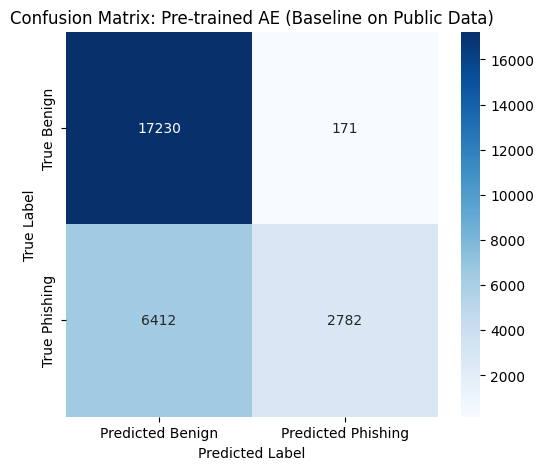

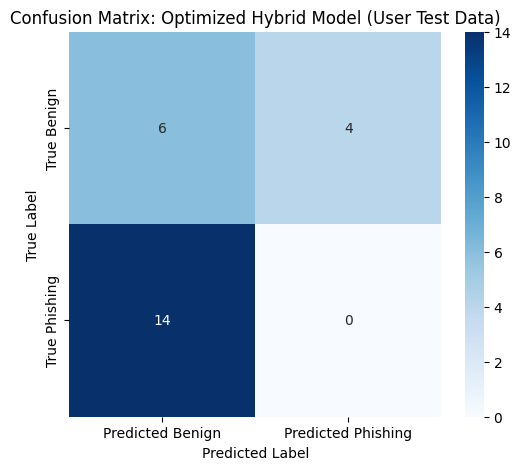

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Benign', 'Predicted Phishing'],
                yticklabels=['True Benign', 'True Phishing'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\n--- Visualizing Confusion Matrices ---")

# Plot Pre-trained AE (Baseline) Confusion Matrix
plot_confusion_matrix(pretrain_stats["confusion_matrix"], "Pre-trained AE (Baseline on Public Data)")

# Plot Optimized Hybrid Model (User Test) Confusion Matrix
if "confusion_matrix" in stats_fusion_user_test:
    plot_confusion_matrix(stats_fusion_user_test["confusion_matrix"], "Optimized Hybrid Model (User Test Data)")
else:
    print("\nSkipping Optimized Hybrid Model (User Test Data) confusion matrix visualization due to missing data.")

* * *

#### **11. Visualize ROC Curves**

Visualize the ROC curves for the different models to compare their performance across various thresholds.


--- Visualizing ROC Curves ---


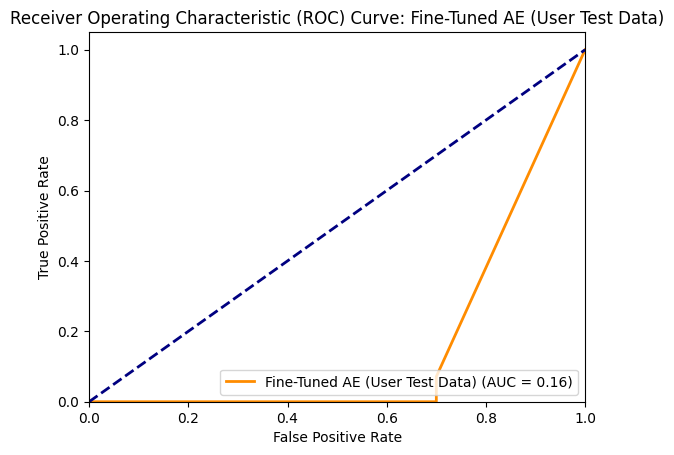

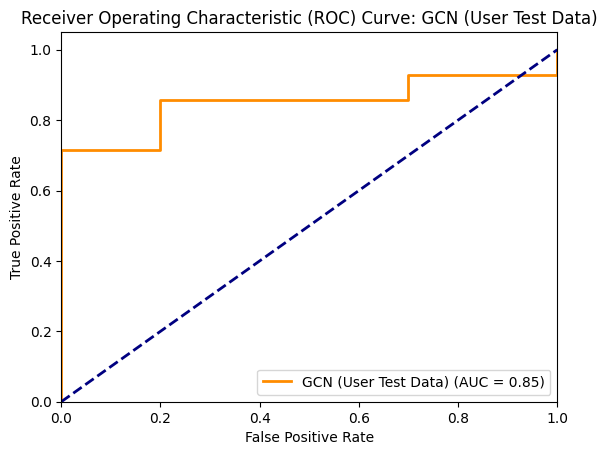

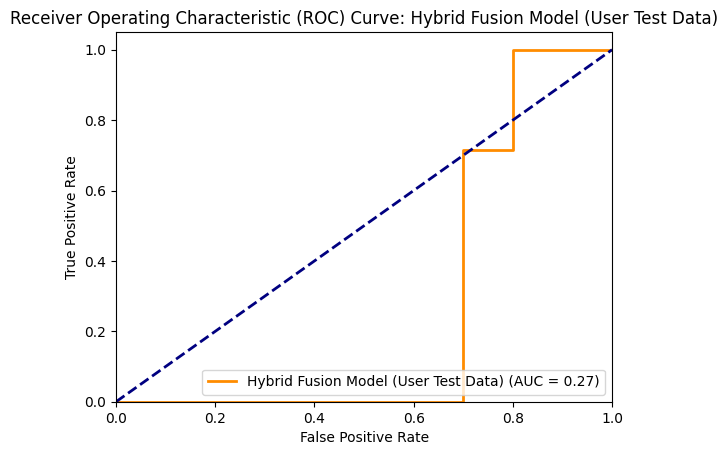


--- Visualizing ROC Curves on Public Test Data (Secondary Benchmark) ---


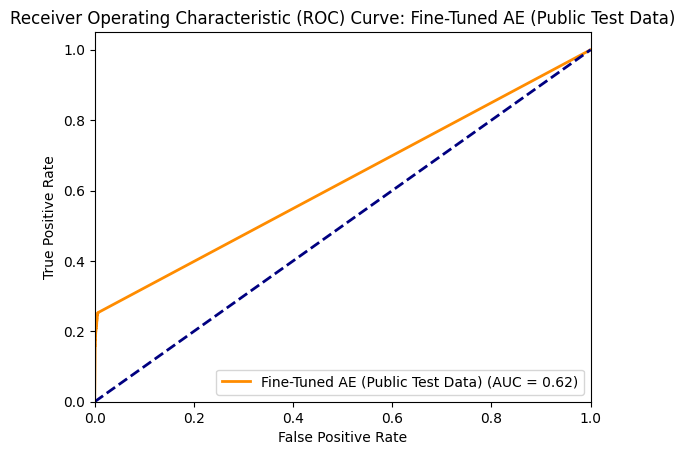

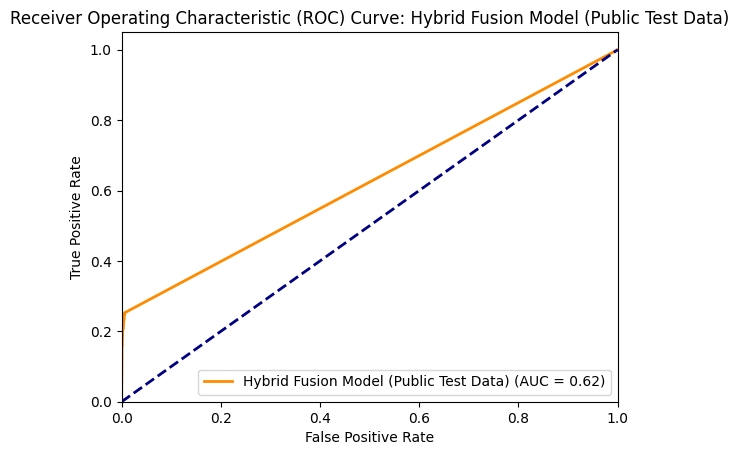

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, model_name):
    if len(np.unique(y_true)) < 2:
        print(f"\nSkipping ROC curve for {model_name}: Only one class present in true labels.")
        return

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

print("\n--- Visualizing ROC Curves ---")

# Plot ROC for Fine-Tuned AE (User Test Data)
if 'ae_post_prob_user_test' in locals() and 'user_test_true_labels' in locals() and len(user_test_true_labels) > 0:
    plot_roc_curve(user_test_true_labels, ae_post_prob_user_test, "Fine-Tuned AE (User Test Data)")
else:
    print("\nSkipping Fine-Tuned AE (User Test Data) ROC curve visualization due to missing data.")

# Plot ROC for GCN (User Test Data)
if 'gcn_prob_user_test' in locals() and 'user_test_true_labels' in locals() and len(user_test_true_labels) > 0:
    plot_roc_curve(user_test_true_labels, gcn_prob_user_test, "GCN (User Test Data)")
else:
    print("\nSkipping GCN (User Test Data) ROC curve visualization due to missing data.")

# Plot ROC for Hybrid Fusion Model (User Test Data)
if 'fusion_prob_user_test' in locals() and 'user_test_true_labels' in locals() and len(user_test_true_labels) > 0:
     plot_roc_curve(user_test_true_labels, fusion_prob_user_test, "Hybrid Fusion Model (User Test Data)")
else:
     print("\nSkipping Hybrid Fusion Model (User Test Data) ROC curve visualization due to missing data.")

# Optionally, keep plotting on Public Test data as a secondary benchmark
print("\n--- Visualizing ROC Curves on Public Test Data (Secondary Benchmark) ---")

# Plot ROC for Fine-Tuned AE (Public Test Data)
if 'ae_prob_test_finetuned' in locals() and 'y_te' in locals() and len(y_te) > 0:
    plot_roc_curve(y_te, ae_prob_test_finetuned, "Fine-Tuned AE (Public Test Data)")
else:
    print("\nSkipping Fine-Tuned AE (Public Test Data) ROC curve visualization due to missing data.")

# Plot ROC for Hybrid Fusion Model (Public Test Data)
if 'fusion_prob_test_public' in locals() and 'y_te' in locals() and len(y_te) > 0:
     plot_roc_curve(y_te, fusion_prob_test_public, "Hybrid Fusion Model (Public Test Data)")
else:
     print("\nSkipping Hybrid Fusion Model (Public Test Data) ROC curve visualization due to missing data.")